In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, when, count, avg, max as spark_max
from pyspark.sql.types import FloatType
# === ALL NECESSARY IMPORTS ===
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lower, rlike, sum as spark_sum, countDistinct
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pyspark.sql.functions import col, min, datediff, when, lit
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style="whitegrid")



In [2]:
# Set up Spark
# spark = SparkSession.builder.appName("MIMIC-IV Diabetic Exploration").getOrCreate()

spark = SparkSession.builder \
    .appName("MIMIC-IV Diabetic Exploration") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "2000") \
    .config("spark.sql.autoBroadcastJoinThreshold", "-1") \
    .config("spark.memory.offHeap.enabled", "true") \
    .config("spark.memory.offHeap.size", "4g") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/07 21:13:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/07/07 21:13:27 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
# Change this path to match your setup
DATA_PATH = "Dataset/mimic-iv-3.1/hosp/"

In [4]:
# 2. LOAD & PREVIEW DATA
# Load core hospital tables
patients_df = spark.read.csv(os.path.join(DATA_PATH, "patients.csv.gz"), header=True, inferSchema=True)
admissions_df = spark.read.csv(os.path.join(DATA_PATH, "admissions.csv.gz"), header=True, inferSchema=True)
diagnoses_df = spark.read.csv(os.path.join(DATA_PATH, "diagnoses_icd.csv.gz"), header=True, inferSchema=True)
labs_df = spark.read.csv(os.path.join(DATA_PATH, "labevents.csv.gz"), header=True, inferSchema=True)
d_icd = spark.read.csv(os.path.join(DATA_PATH, "d_icd_diagnoses.csv.gz"), header=True, inferSchema=True)
d_labitems_df = spark.read.csv(os.path.join(DATA_PATH, "d_labitems.csv.gz"), header=True, inferSchema=True)


print("Loaded tables: patients, admissions, diagnoses_icd, labevents")



25/07/07 21:13:42 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Loaded tables: patients, admissions, diagnoses_icd, labevents


#### Print Schema and Record Count for Each Table

In [5]:
# === DISPLAY SCHEMAS ===
for name, df in {
    "patients": patients_df,
    "admissions": admissions_df,
    "diagnoses": diagnoses_df,
    "labs": labs_df,
    "icd_ref": d_icd
}.items():
    print(f"\n📄 {name.upper()} TABLE")
    df.printSchema()
    print(f"✅ Row count: {df.count()}")


📄 PATIENTS TABLE
root
 |-- subject_id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- anchor_age: integer (nullable = true)
 |-- anchor_year: integer (nullable = true)
 |-- anchor_year_group: string (nullable = true)
 |-- dod: date (nullable = true)

✅ Row count: 364627

📄 ADMISSIONS TABLE
root
 |-- subject_id: integer (nullable = true)
 |-- hadm_id: integer (nullable = true)
 |-- admittime: timestamp (nullable = true)
 |-- dischtime: timestamp (nullable = true)
 |-- deathtime: timestamp (nullable = true)
 |-- admission_type: string (nullable = true)
 |-- admit_provider_id: string (nullable = true)
 |-- admission_location: string (nullable = true)
 |-- discharge_location: string (nullable = true)
 |-- insurance: string (nullable = true)
 |-- language: string (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- race: string (nullable = true)
 |-- edregtime: timestamp (nullable = true)
 |-- edouttime: timestamp (nullable = true)
 |-- hospital_expire

✅ Row count: 546028

📄 DIAGNOSES TABLE
root
 |-- subject_id: integer (nullable = true)
 |-- hadm_id: integer (nullable = true)
 |-- seq_num: integer (nullable = true)
 |-- icd_code: string (nullable = true)
 |-- icd_version: integer (nullable = true)



✅ Row count: 6364488

📄 LABS TABLE
root
 |-- labevent_id: integer (nullable = true)
 |-- subject_id: integer (nullable = true)
 |-- hadm_id: integer (nullable = true)
 |-- specimen_id: integer (nullable = true)
 |-- itemid: integer (nullable = true)
 |-- order_provider_id: string (nullable = true)
 |-- charttime: timestamp (nullable = true)
 |-- storetime: timestamp (nullable = true)
 |-- value: string (nullable = true)
 |-- valuenum: double (nullable = true)
 |-- valueuom: string (nullable = true)
 |-- ref_range_lower: double (nullable = true)
 |-- ref_range_upper: double (nullable = true)
 |-- flag: string (nullable = true)
 |-- priority: string (nullable = true)
 |-- comments: string (nullable = true)



✅ Row count: 158374764

📄 ICD_REF TABLE
root
 |-- icd_code: string (nullable = true)
 |-- icd_version: integer (nullable = true)
 |-- long_title: string (nullable = true)

✅ Row count: 112107


#### Display 5 Sample Rows from Each Table

In [6]:
for name, df in {
    "patients": patients_df,
    "admissions": admissions_df,
    "diagnoses": diagnoses_df,
    "labs": labs_df,
    "icd_ref": d_icd
}.items():
    print(f"\n🔍 Sample from {name.upper()}:")
    df.show(5)



🔍 Sample from PATIENTS:
+----------+------+----------+-----------+-----------------+----------+
|subject_id|gender|anchor_age|anchor_year|anchor_year_group|       dod|
+----------+------+----------+-----------+-----------------+----------+
|  10000032|     F|        52|       2180|      2014 - 2016|2180-09-09|
|  10000048|     F|        23|       2126|      2008 - 2010|      NULL|
|  10000058|     F|        33|       2168|      2020 - 2022|      NULL|
|  10000068|     F|        19|       2160|      2008 - 2010|      NULL|
|  10000084|     M|        72|       2160|      2017 - 2019|2161-02-13|
+----------+------+----------+-----------+-----------------+----------+
only showing top 5 rows


🔍 Sample from ADMISSIONS:
+----------+--------+-------------------+-------------------+---------+--------------+-----------------+--------------------+------------------+---------+--------+--------------+-----+-------------------+-------------------+--------------------+
|subject_id| hadm_id|        

In [7]:
# ---- STEP 1: Identify diabetic patients
diabetic_df = diagnoses_df.filter(lower(col("icd_code")).startswith("250")).select("subject_id").distinct()
print(f"Diabetic patients identified: {diabetic_df.count()}")

diabetic_df.show(5)

Diabetic patients identified: 25593


+----------+
|subject_id|
+----------+
|  10012942|
|  10334189|
|  10387770|
|  10509699|
|  10663941|
+----------+
only showing top 5 rows



In [8]:
# ---- STEP 3: Define complication conditions

# complication_conditions = {
#     "retinopathy": ["25050", "25051", "36201", "36202", "36210", "36211", "36212"], # Diabetic retinopathy
#     "neuropathy": ["25060", "25061", "3572", "3569", "35789"], # Diabetic polyneuropathy
#     "nephropathy": ["25040", "25041", "58381", "5939"], # Chronic kidney disease
#     "cardiovascular": ["25070", "25071", "41401", "4292"], # Ischemic heart diseases
#     "foot_ulcer": ["70715", "7071", "70710", "25080", "25081"], # Chronic ulcer of skin
# }

complication_conditions = {
    "neuropathy": ["25060", "25061", "3572", "3569", "35789"], # Diabetic polyneuropathy
    "cardiovascular": ["25070", "25071", "41401", "4292"], # Ischemic heart diseases
}


In [9]:
from pyspark.sql.functions import sum as spark_sum

# Step 1: Add complication columns
for complication, codes in complication_conditions.items():
    # For each complication, create a new column that checks if the icd_code is in the list
    diagnoses_df = diagnoses_df.withColumn(
        f"comp_{complication}",
        F.when(F.lower(F.col("icd_code")).isin(codes), 1).otherwise(0)
    )


# Columns already added in diagnoses_df: comp_retinopathy, comp_neuropathy, etc.
# complication_cols = [
#     "comp_retinopathy",
#     "comp_neuropathy",
#     "comp_nephropathy",
#     "comp_cardiovascular",
#     "comp_foot_ulcer"
# ]
complication_cols = [
    "comp_neuropathy",
    "comp_cardiovascular"
]

# Aggregate per patient
complications_df = diagnoses_df.groupBy("subject_id").agg(
    *[spark_sum(col(c)).alias(c) for c in complication_cols]
)

# Join with diabetic patients
diabetic_df = diabetic_df.distinct()
full_diabetic_df = diabetic_df.join(complications_df, on="subject_id", how="left").fillna(0)

# Show complication distribution
full_diabetic_df.select([
    spark_sum(col(c)).alias(f"{c}_count") for c in complication_cols
]).show()


+---------------------+-------------------------+
|comp_neuropathy_count|comp_cardiovascular_count|
+---------------------+-------------------------+
|                19625|                    18276|
+---------------------+-------------------------+



In [10]:
diabetic_df.printSchema()
diabetic_df.columns


root
 |-- subject_id: integer (nullable = true)



['subject_id']

#### Merge with Demographics + Admissions

In [11]:
# STEP 2 FIXED: Merge patients and admissions with correct columns
# Merge demographics (from patients)
enriched_df = full_diabetic_df.join(patients_df, on="subject_id", how="left")

# Merge admission details (race, marital_status, hospital_expire_flag, etc.)
enriched_df = enriched_df.join(
    admissions_df.select(
        "subject_id", "hadm_id", "admittime", "dischtime",
        "hospital_expire_flag", "admission_type",
        "race", "marital_status"
    ),
    on="subject_id", how="left"
)

# Preview with correct columns
enriched_df.select(
    "subject_id", "gender", "anchor_age", "race", "marital_status",
    "hospital_expire_flag", "admission_type", *complication_cols
).show(5)


+----------+------+----------+--------------------+--------------+--------------------+--------------------+---------------+-------------------+
|subject_id|gender|anchor_age|                race|marital_status|hospital_expire_flag|      admission_type|comp_neuropathy|comp_cardiovascular|
+----------+------+----------+--------------------+--------------+--------------------+--------------------+---------------+-------------------+
|  10012942|     F|        45|HISPANIC/LATINO -...|       MARRIED|                   0|            EW EMER.|              0|                  0|
|  10334189|     F|        91|               WHITE|       WIDOWED|                   0|            EW EMER.|              0|                  0|
|  10334189|     F|        91|               WHITE|       WIDOWED|                   0|AMBULATORY OBSERV...|              0|                  0|
|  10387770|     M|        82|               WHITE|       MARRIED|                   0|   OBSERVATION ADMIT|              5|      

##### Demographics Overview

In [12]:
from pyspark.sql.functions import count, avg

# Gender distribution
enriched_df.groupBy("gender").count().show()

# Race distribution
enriched_df.groupBy("race").count().orderBy("count", ascending=False).show()

# Marital status
enriched_df.groupBy("marital_status").count().orderBy("count", ascending=False).show()

# Average age
enriched_df.select(avg("anchor_age").alias("average_age")).show()


+------+-----+
|gender|count|
+------+-----+
|     M|58345|
|     F|53297|
+------+-----+



+--------------------+-----+
|                race|count|
+--------------------+-----+
|               WHITE|62691|
|BLACK/AFRICAN AME...|23834|
|               OTHER| 3388|
|HISPANIC/LATINO -...| 3269|
|  HISPANIC OR LATINO| 2852|
|     WHITE - RUSSIAN| 2047|
|WHITE - OTHER EUR...| 1642|
|             UNKNOWN| 1333|
|  BLACK/CAPE VERDEAN| 1275|
|     ASIAN - CHINESE| 1216|
|HISPANIC/LATINO -...| 1215|
|BLACK/CARIBBEAN I...| 1048|
|               ASIAN|  947|
|       BLACK/AFRICAN|  606|
|          PORTUGUESE|  561|
|    UNABLE TO OBTAIN|  404|
|ASIAN - SOUTH EAS...|  399|
|PATIENT DECLINED ...|  337|
|ASIAN - ASIAN INDIAN|  324|
|HISPANIC/LATINO -...|  318|
+--------------------+-----+
only showing top 20 rows



+--------------+-----+
|marital_status|count|
+--------------+-----+
|       MARRIED|47547|
|        SINGLE|37781|
|       WIDOWED|15701|
|      DIVORCED| 9559|
|          NULL| 1054|
+--------------+-----+



+------------------+
|       average_age|
+------------------+
|62.850056430375666|
+------------------+



##### Admission Type and Mortality

In [13]:
# Admission types
enriched_df.groupBy("admission_type").count().orderBy("count", ascending=False).show()

# Mortality flag distribution
enriched_df.groupBy("hospital_expire_flag").count().show()


+--------------------+-----+
|      admission_type|count|
+--------------------+-----+
|            EW EMER.|48663|
|      EU OBSERVATION|20418|
|   OBSERVATION ADMIT|12554|
|              URGENT| 8066|
|SURGICAL SAME DAY...| 7015|
|        DIRECT EMER.| 6201|
|  DIRECT OBSERVATION| 4160|
|            ELECTIVE| 2455|
|AMBULATORY OBSERV...| 2110|
+--------------------+-----+



+--------------------+------+
|hospital_expire_flag| count|
+--------------------+------+
|                   1|  2443|
|                   0|109199|
+--------------------+------+



##### Complication Distribution

In [14]:
from pyspark.sql.functions import sum as spark_sum

# complication_cols = [
#     "comp_retinopathy", "comp_neuropathy", "comp_nephropathy",
#     "comp_cardiovascular", "comp_foot_ulcer"
# ]

complication_cols = [
     "comp_neuropathy", "comp_cardiovascular"
]
# Sum total cases of each complication
enriched_df.select([
    spark_sum(col(c)).alias(f"{c}_count") for c in complication_cols
]).show()


+---------------------+-------------------------+
|comp_neuropathy_count|comp_cardiovascular_count|
+---------------------+-------------------------+
|               281639|                   199567|
+---------------------+-------------------------+



#### Visualize Diabetic Cohort

In [15]:
# Convert to Pandas for plotting
#PS: REMOVED THE OTHER COMPLICATIONS HERE!
plot_df = enriched_df.select(
    "gender", "anchor_age", "race", "marital_status", "admission_type", "hospital_expire_flag", "comp_neuropathy", "comp_cardiovascular",
).toPandas()


##### Gender Distribution

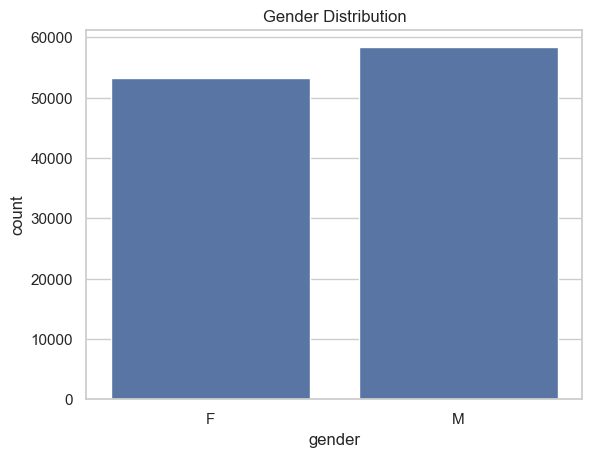

In [16]:
sns.countplot(data=plot_df, x='gender')
plt.title("Gender Distribution")
plt.show()


##### Age Distribution

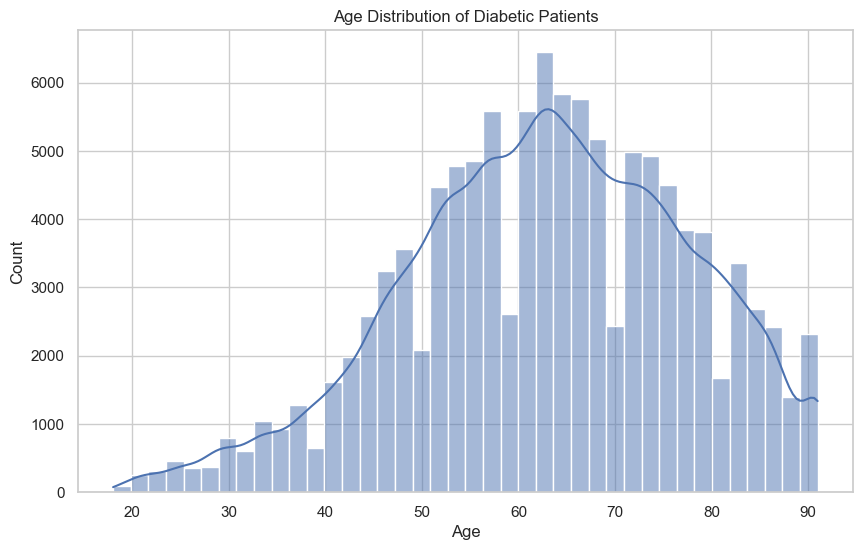

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(plot_df['anchor_age'], bins=40, kde=True)
plt.title("Age Distribution of Diabetic Patients")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


##### Complications Bar Chart

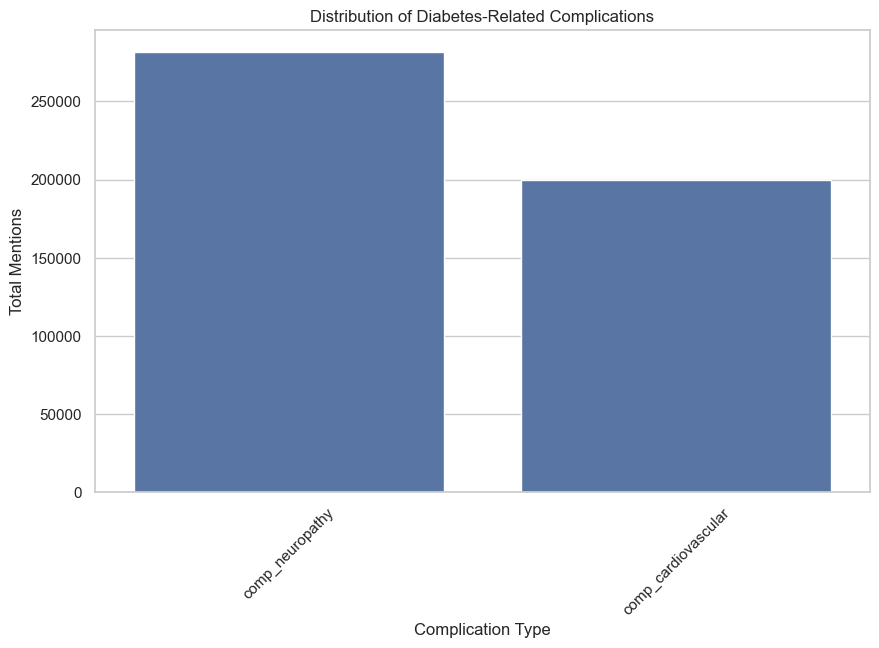

In [18]:
# complication_cols = ["comp_retinopathy", "comp_neuropathy", "comp_nephropathy", "comp_cardiovascular", "comp_foot_ulcer"]
complication_cols = ["comp_neuropathy", "comp_cardiovascular"]
comp_counts = plot_df[complication_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=comp_counts.index, y=comp_counts.values)
plt.title("Distribution of Diabetes-Related Complications")
plt.ylabel("Total Mentions")
plt.xlabel("Complication Type")
plt.xticks(rotation=45)
plt.show()


##### Race Breakdown (Top 10)

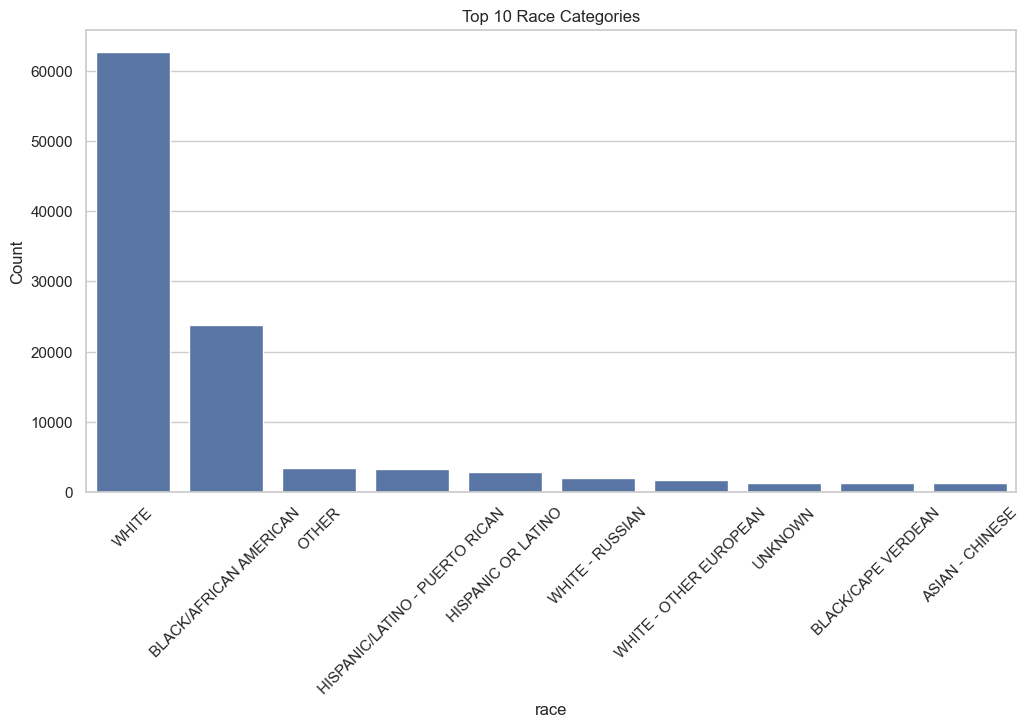

In [19]:
top_races = plot_df['race'].value_counts().head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_races.index, y=top_races.values)
plt.title("Top 10 Race Categories")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()


##### Admission Type Breakdown

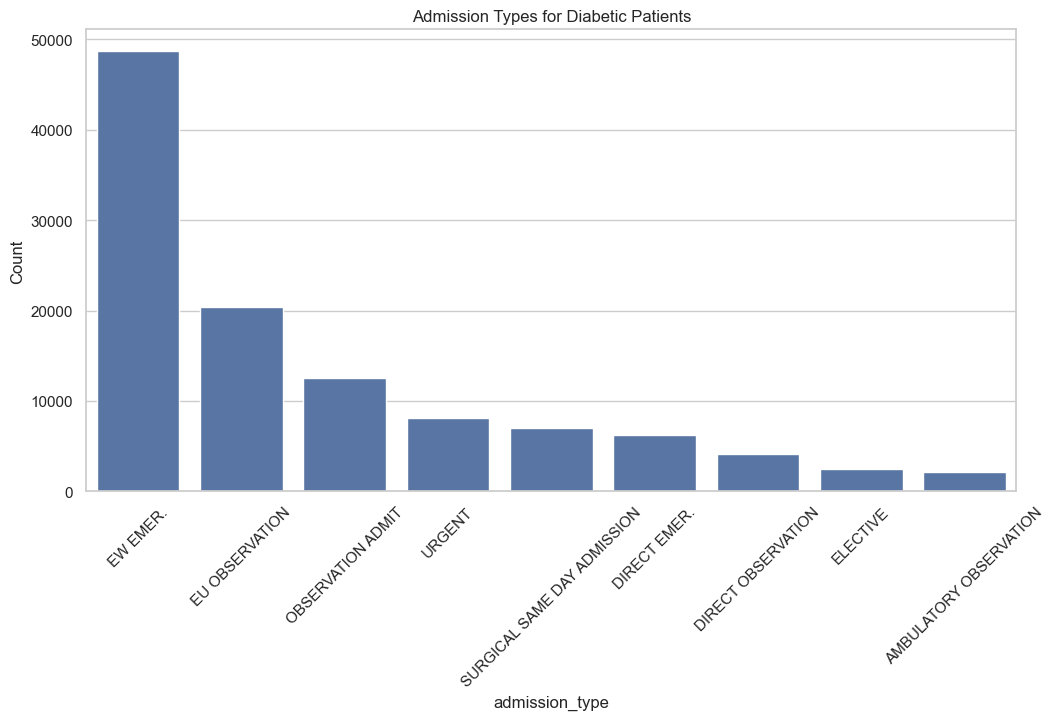

In [20]:
top_admissions = plot_df['admission_type'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(x=top_admissions.index, y=top_admissions.values)
plt.title("Admission Types for Diabetic Patients")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()


##### Identify Diabetes-Relevant Lab Tests

In [21]:
#inspect d_labitems_df
d_labitems_df.printSchema()
print(f"✅ Row count: {d_labitems_df.count()}")


root
 |-- itemid: integer (nullable = true)
 |-- label: string (nullable = true)
 |-- fluid: string (nullable = true)
 |-- category: string (nullable = true)

✅ Row count: 1650


In [22]:

d_labitems_df.select("itemid", "label", "fluid", "category").show(20, truncate=False)

+------+-----------------------------------+-----+---------+
|itemid|label                              |fluid|category |
+------+-----------------------------------+-----+---------+
|50801 |Alveolar-arterial Gradient         |Blood|Blood Gas|
|50802 |Base Excess                        |Blood|Blood Gas|
|50803 |Calculated Bicarbonate, Whole Blood|Blood|Blood Gas|
|50804 |Calculated Total CO2               |Blood|Blood Gas|
|50805 |Carboxyhemoglobin                  |Blood|Blood Gas|
|50806 |Chloride, Whole Blood              |Blood|Blood Gas|
|50808 |Free Calcium                       |Blood|Blood Gas|
|50809 |Glucose                            |Blood|Blood Gas|
|50810 |Hematocrit, Calculated             |Blood|Blood Gas|
|50811 |Hemoglobin                         |Blood|Blood Gas|
|50812 |Intubated                          |Blood|Blood Gas|
|50813 |Lactate                            |Blood|Blood Gas|
|50814 |Methemoglobin                      |Blood|Blood Gas|
|50815 |O2 Flow         

In [23]:
# keywords = ["glucose", "creatinine", "a1c", "albumin", "bun", "cholesterol", "ldl", "hdl", "triglyceride", "crp"]

keywords = ["glucose", "creatinine", "a1c", "albumin", "cholesterol", "ldl", "hdl", "triglyceride"]

for kw in keywords:
    print(f"\n🔍 Searching for: {kw}")
    d_labitems_df.filter(lower(col("label")).contains(kw))\
                 .select("itemid", "label", "fluid", "category")\
                 .distinct().show(50, truncate=False)



🔍 Searching for: glucose
+------+--------------------+-------------------+----------+
|itemid|label               |fluid              |category  |
+------+--------------------+-------------------+----------+
|51084 |Glucose, Urine      |Urine              |Chemistry |
|51034 |Glucose, Body Fluid |Other Body Fluid   |Chemistry |
|50842 |Glucose, Ascites    |Ascites            |Chemistry |
|52569 |Glucose             |Blood              |Chemistry |
|51022 |Glucose, Joint Fluid|Joint Fluid        |Chemistry |
|51053 |Glucose, Pleural    |Pleural            |Chemistry |
|50931 |Glucose             |Blood              |Chemistry |
|51790 |Glucose, CSF        |Cerebrospinal Fluid|Chemistry |
|50809 |Glucose             |Blood              |Blood Gas |
|52027 |Glucose, Whole Blood|Blood              |Blood Gas |
|51981 |Glucose             |Urine              |Chemistry |
|51941 |Glucose, Stool      |Stool              |Chemistry |
|51478 |Glucose             |Urine              |Hematology

#### Lab Events Filtering

##### Lab Tests for Diabetic Complications

In [24]:

# 🧪 Step 3: Define final list of selected lab itemids
selected_lab_items = {
    "glucose": 50931,
    "a1c": 50852,
    "creatinine": 50912,
    "albumin": 50862,
    "albumin_creatinine_ratio": 51070,
    "ldl": 50906,
    "hdl": 50904,
    "triglycerides": 51000,

}
#Removing the CRP & BUN as they don't have any patient data within the working time window

#"crp": 51652 | "bun": 51842,

#  Step 2: Convert to list explicitly
selected_item_ids = list(selected_lab_items.values())

#  Step 3: Filter labs
filtered_labs_df = labs_df.filter(col("itemid").isin(selected_item_ids))

# Step 4: Preview
print("Filtered lab events (relevant to diabetic complications):")
filtered_labs_df.select("subject_id", "itemid", "charttime", "value", "valuenum", "valueuom").show(10)

Filtered lab events (relevant to diabetic complications):
+----------+------+-------------------+-----+--------+--------+
|subject_id|itemid|          charttime|value|valuenum|valueuom|
+----------+------+-------------------+-----+--------+--------+
|  10000032| 50931|2180-03-23 11:51:00|  ___|    95.0|   mg/dL|
|  10000032| 50862|2180-03-23 11:51:00|  3.3|     3.3|    g/dL|
|  10000032| 50904|2180-03-23 11:51:00|   52|    52.0|   mg/dL|
|  10000032| 50912|2180-03-23 11:51:00|  0.4|     0.4|   mg/dL|
|  10000032| 51000|2180-03-23 11:51:00|  ___|    73.0|   mg/dL|
|  10000032| 50862|2180-05-06 22:25:00|  3.3|     3.3|    g/dL|
|  10000032| 50912|2180-05-06 22:25:00|  0.3|     0.3|   mg/dL|
|  10000032| 50931|2180-05-06 22:25:00|  ___|   109.0|   mg/dL|
|  10000032| 50912|2180-05-07 05:05:00|  0.3|     0.3|   mg/dL|
|  10000032| 50931|2180-05-07 05:05:00|  ___|    99.0|   mg/dL|
+----------+------+-------------------+-----+--------+--------+
only showing top 10 rows



#### Aggregate Lab Features per Patient

In [25]:
from pyspark.sql.functions import mean, max, count, when
from pyspark.sql import functions as F

# Map itemid back to readable labname
lab_id_to_name = {v: k for k, v in selected_lab_items.items()}
lab_mapping_expr = F.create_map([F.lit(x) for pair in lab_id_to_name.items() for x in pair])
labeled_labs_df = filtered_labs_df.withColumn("labname", lab_mapping_expr[col("itemid")])

# Group by subject_id and labname and aggregate
agg_labs_df = labeled_labs_df.groupBy("subject_id", "labname").agg(
    mean("valuenum").alias("lab_mean"),
    max("valuenum").alias("lab_max"),
    count("valuenum").alias("lab_count")
)

# Pivot so each labname becomes a column
pivot_labs_df = agg_labs_df.groupBy("subject_id").pivot("labname").agg(
    F.first("lab_mean").alias("mean"),
    F.first("lab_max").alias("max"),
    F.first("lab_count").alias("count")
)

# Preview
pivot_labs_df.show(5, truncate=False)


+----------+-----------------+-------+---------+------------------+-----------+-------------+-----------------------------+----------------------------+------------------------------+------------------+--------------+----------------+------------------+-----------+-------------+--------+-------+---------+--------+-------+---------+------------------+-----------------+-------------------+
|subject_id|a1c_mean         |a1c_max|a1c_count|albumin_mean      |albumin_max|albumin_count|albumin_creatinine_ratio_mean|albumin_creatinine_ratio_max|albumin_creatinine_ratio_count|creatinine_mean   |creatinine_max|creatinine_count|glucose_mean      |glucose_max|glucose_count|hdl_mean|hdl_max|hdl_count|ldl_mean|ldl_max|ldl_count|triglycerides_mean|triglycerides_max|triglycerides_count|
+----------+-----------------+-------+---------+------------------+-----------+-------------+-----------------------------+----------------------------+------------------------------+------------------+--------------+-

#### Time-to-Complication Analysis

In [26]:
# --- Get each patient's first admission time ---
first_admit_df = admissions_df.groupBy("subject_id").agg(
    F.min("admittime").alias("first_admit_time")
)

In [27]:

 # --- 3. Create an empty list to store results ---
time_to_complications = []

# --- 4. Loop through each complication type ---
for comp, icd_list in complication_conditions.items():
    print(f"🔍 Processing {comp}...")

    # Filter diagnoses by complication-specific ICD codes
    comp_df = diagnoses_df.filter(
        col("icd_code").isin(icd_list)
    ).select("subject_id", "hadm_id")

    # Join with admissions to get admit time of that diagnosis
    comp_admit_df = comp_df.join(
        admissions_df.select("subject_id", "hadm_id", "admittime"),
        on=["subject_id", "hadm_id"],
        how="inner"
    ).groupBy("subject_id").agg(
        min("admittime").alias(f"{comp}_admit_time")
    )

    # Join with first admit time to compute days_to_complication
    comp_days_df = comp_admit_df.join(first_admit_df, on="subject_id") \
        .withColumn(f"days_to_{comp}", datediff(col(f"{comp}_admit_time"), col("first_admit_time")))

    # Save to list for documentation or further analysis
    time_to_complications.append(comp_days_df.select("subject_id", f"days_to_{comp}"))


🔍 Processing neuropathy...
🔍 Processing cardiovascular...


In [28]:
# --- 5. Join all complications together on subject_id ---
from functools import reduce

time_df = reduce(lambda df1, df2: df1.join(df2, on="subject_id", how="outer"), time_to_complications)

# --- 6. Show result ---
time_df.orderBy("subject_id").show(10, truncate=False)

+----------+------------------+----------------------+
|subject_id|days_to_neuropathy|days_to_cardiovascular|
+----------+------------------+----------------------+
|10000690  |NULL              |122                   |
|10000764  |NULL              |0                     |
|10000980  |1186              |541                   |
|10001176  |NULL              |0                     |
|10001884  |NULL              |0                     |
|10002013  |1420              |0                     |
|10002155  |NULL              |371                   |
|10002976  |NULL              |0                     |
|10003052  |NULL              |0                     |
|10003299  |NULL              |2038                  |
+----------+------------------+----------------------+
only showing top 10 rows



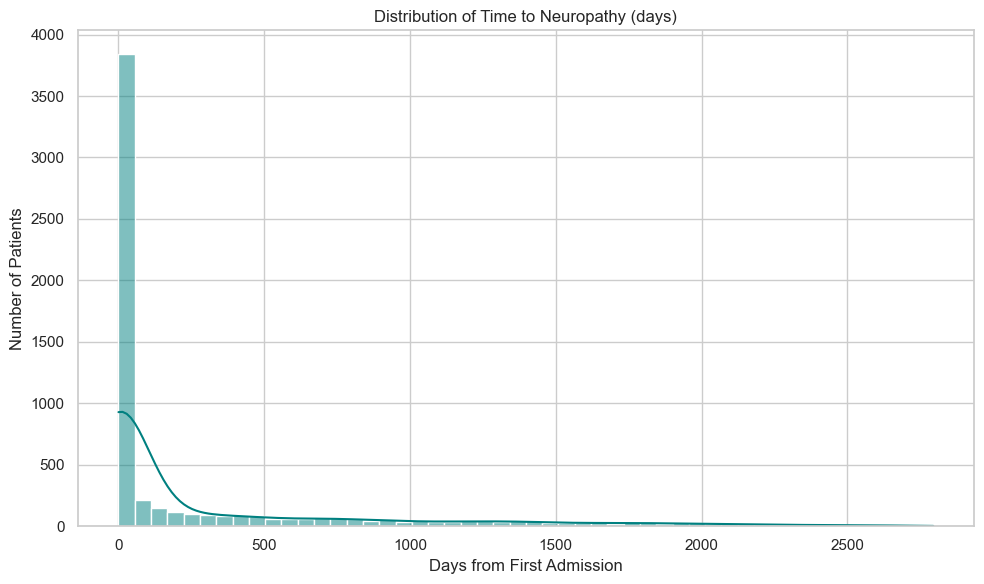

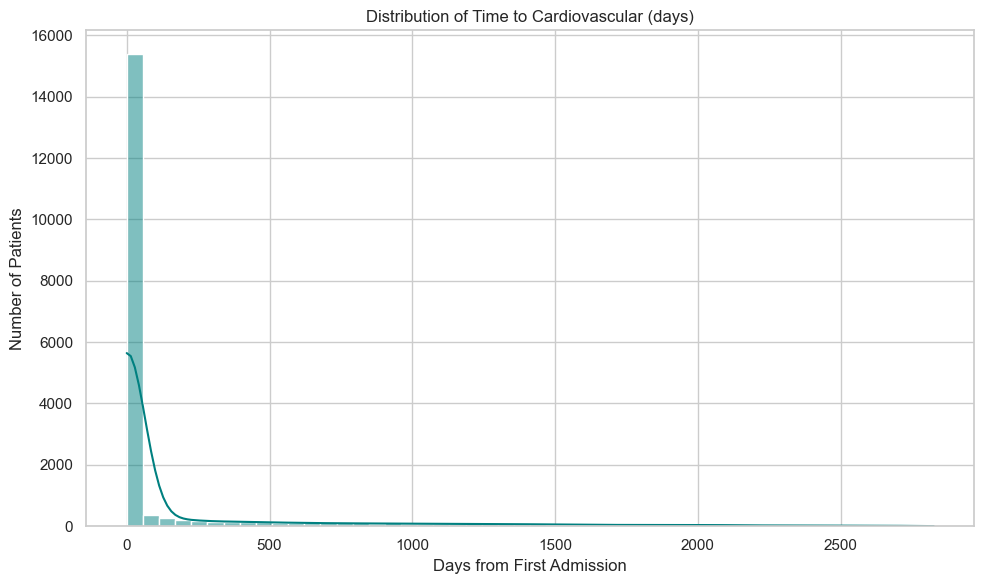

In [29]:


# Convert to Pandas for local plotting
plot_df = time_df.toPandas()

# Complication columns to visualize
complication_time_cols = [
    "days_to_neuropathy",
    "days_to_cardiovascular",
]

# Set plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Loop and plot histograms for each complication delay
for comp_col in complication_time_cols:
    comp_data = plot_df[comp_col].dropna()
    if comp_data.empty:
        print(f"⚠️ Skipping {comp_col} — no data.")
        continue

    plt.figure()
    sns.histplot(comp_data, bins=50, kde=True, color="teal")
    plt.title(f"Distribution of Time to {comp_col.replace('days_to_', '').capitalize()} (days)")
    plt.xlabel("Days from First Admission")
    plt.ylabel("Number of Patients")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


#### Compute % Diagnosed Within 90 and 180 Days

In [30]:
def get_complication_proportions(df, complication_columns, days_list=[90, 180]):
    results = []
    for comp_col in complication_columns:
        comp_name = comp_col.replace("days_to_", "")
        total = df.filter(col(comp_col).isNotNull()).count()
        for d in days_list:
            within_d = df.filter((col(comp_col).isNotNull()) & (col(comp_col) <= d)).count()
            pct = round((within_d / total) * 100, 2) if total > 0 else 0.0
            results.append((comp_name, d, pct))
    return spark.createDataFrame(results, ["complication", "days_window", "percent_within"])

# Example usage
complication_cols = [col for col in time_df.columns if col.startswith("days_to_")]
percent_df = get_complication_proportions(time_df, complication_cols)
percent_df.show()


+--------------+-----------+--------------+
|  complication|days_window|percent_within|
+--------------+-----------+--------------+
|    neuropathy|         90|         66.77|
|    neuropathy|        180|         70.99|
|cardiovascular|         90|         81.91|
|cardiovascular|        180|         84.03|
+--------------+-----------+--------------+



##### Clustered Bar Chart

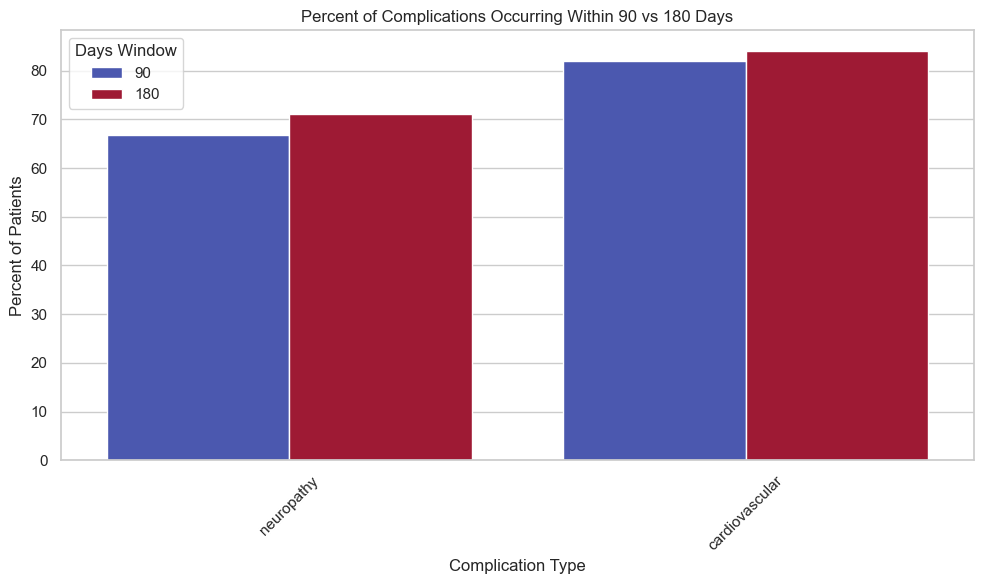

In [31]:

# Convert to Pandas
pdf = percent_df.toPandas()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=pdf, x="complication", y="percent_within", hue="days_window", palette="coolwarm")

plt.title("Percent of Complications Occurring Within 90 vs 180 Days")
plt.ylabel("Percent of Patients")
plt.xlabel("Complication Type")
plt.legend(title="Days Window")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##### Count Diagnoses Within vs After 180 Days

In [32]:
from pyspark.sql.functions import col, when, count

# Define time window
cutoff = 180

# Prepare a list to store results
counts_by_complication = []

# Loop through each complication and compute within/after-180d stats
for comp in [ "neuropathy", "cardiovascular"]:
    # Only look at rows where the days_to_complication is not null
    comp_valid = time_df.filter(col(f"days_to_{comp}").isNotNull())

    # Classify as within or after 180 days
    comp_classified = comp_valid.withColumn(
        "time_window",
        when(col(f"days_to_{comp}") <= cutoff, "within_180d").otherwise("after_180d")
    )

    # Count the classifications
    comp_counts = comp_classified.groupBy("time_window").agg(count("*").alias("count"))

    # Add a column to tag which complication it is
    comp_counts = comp_counts.withColumn("complication", F.lit(comp))

    counts_by_complication.append(comp_counts)

# Combine all into a single DataFrame
diagnosis_window_counts_df = reduce(lambda df1, df2: df1.unionByName(df2), counts_by_complication)

# Reorder for clarity
diagnosis_window_counts_df = diagnosis_window_counts_df.select("complication", "time_window", "count")

# Display the result
diagnosis_window_counts_df.orderBy("complication", "time_window").show(50, truncate=False)


+--------------+-----------+-----+
|complication  |time_window|count|
+--------------+-----------+-----+
|cardiovascular|after_180d |3047 |
|cardiovascular|within_180d|16035|
|neuropathy    |after_180d |1727 |
|neuropathy    |within_180d|4226 |
+--------------+-----------+-----+



In [33]:
# convert to Pandas
diagnosis_window_counts_pd = diagnosis_window_counts_df.toPandas()

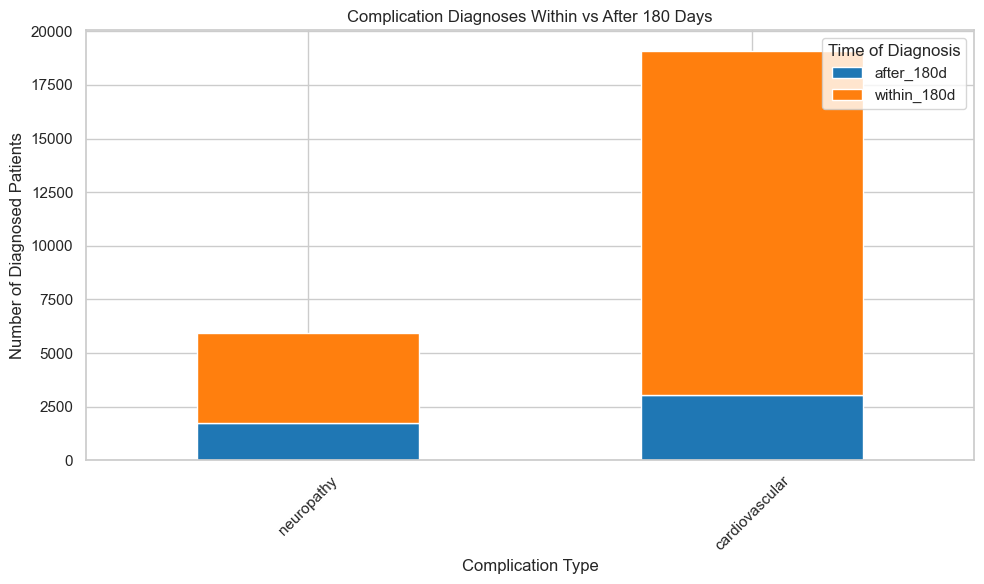

In [34]:
# Pivot the data
pivot_df = diagnosis_window_counts_pd.pivot(
    index='complication',
    columns='time_window',
    values='count'
).fillna(0)

# Sort complications for visual consistency
pivot_df = pivot_df.loc[[ "neuropathy","cardiovascular"]]

# Plot
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#1f77b4', '#ff7f0e'])

# Labels and title
plt.ylabel("Number of Diagnosed Patients")
plt.xlabel("Complication Type")
plt.title("Complication Diagnoses Within vs After 180 Days")
plt.xticks(rotation=45)
plt.legend(title="Time of Diagnosis", loc="upper right")
plt.tight_layout()

plt.show()


##### Define Time Windows

In [35]:
# Step 1: Define optimized baseline-horizon windows per complication
time_windows = {
    "cardiovascular": (30, 730),
    "neuropathy": (90, 365)
}


##### Generate Time-to-Complication Labels

In [36]:

# Join complications with diagnosis date
diabetes_dx = first_admit_df.select("subject_id", F.col("first_admit_time").alias("diag_date"))

# This should already exist: multi_label has all complications
multi_with_diag = time_df.join(diabetes_dx, "subject_id")

# Create time-to-complication columns
# --- Apply condition-specific windows to create binary labels ---
for comp, (baseline, horizon) in time_windows.items():
    days_col = f"days_to_{comp}"
    label_col = f"{comp}_label"

    time_df = time_df.withColumn(
        label_col,
        when(
            (col(days_col).isNotNull()) &
            (col(days_col) > baseline) &
            (col(days_col) <= (baseline + horizon)),
            1
        ).otherwise(0)
    )


In [37]:
time_df.select("subject_id", *[f"{comp}_label" for comp in time_windows]).show(10)


+----------+--------------------+----------------+
|subject_id|cardiovascular_label|neuropathy_label|
+----------+--------------------+----------------+
|  10000980|                   1|               0|
|  10004422|                   0|               0|
|  10005348|                   0|               0|
|  10005565|                   0|               0|
|  10008100|                   0|               0|
|  10009635|                   0|               0|
|  10010424|                   0|               0|
|  10011668|                   1|               0|
|  10015860|                   0|               0|
|  10016367|                   1|               0|
+----------+--------------------+----------------+
only showing top 10 rows



##### Enforce Minimum Follow-Up

In [38]:
from pyspark.sql.functions import col, datediff, max as spark_max, min as spark_min

# Step 1: Calculate max required follow-up duration (baseline + horizon + 90d buffer)
# Use built-in max here since it's just a Python list comprehension
import builtins
max_required_days = builtins.max([b + h for b, h in time_windows.values()]) + 90

# Step 2: Compute min(admittime) and max(dischtime)
followup_df = admissions_df.groupBy("subject_id").agg(
    spark_min("admittime").alias("min_admittime"),
    spark_max("dischtime").alias("max_dischtime")
)

# Step 2b: Compute actual follow-up duration
followup_df = followup_df.withColumn(
    "followup_days",
    datediff(col("max_dischtime"), col("min_admittime"))
)

# Step 3: Join and filter patients who have sufficient follow-up
labeled_df = time_df.join(followup_df, on="subject_id")
labeled_df = labeled_df.filter(col("followup_days") >= max_required_days)


##### Show Final Label Distribution

In [39]:
# Step 5: Print counts of each label
total = labeled_df.count()
for comp in time_windows.keys():
    label_col = f"{comp}_label"
    count = labeled_df.filter(F.col(label_col) == 1).count()
    print(f"{comp}: {count}/{total} = {(count / total * 100):.2f}%")


cardiovascular: 1150/9541 = 12.05%


neuropathy: 381/9541 = 3.99%


##### check coverage of key lab tests per complication

In [40]:
confirmed_diabetes_codes = ["250", "E10", "E11"]  # ICD9 and ICD10 base codes

first_diabetes_dx = diagnoses_df.filter(
    F.col("icd_code").rlike("^(" + "|".join(confirmed_diabetes_codes) + ")")
).join(admissions_df.select("subject_id", "hadm_id", "admittime"),
       on=["subject_id", "hadm_id"], how="left") \
 .groupBy("subject_id").agg(
     F.min("admittime").alias("diag_date")
)


In [41]:
from pyspark.sql.functions import col, countDistinct

# Filter for relevant labs
relevant_itemids = list(selected_lab_items.values())
filtered_labs = labs_df.filter(col("itemid").isin(relevant_itemids))

# Join lab events with diabetes diagnosis date
lab_with_diag = filtered_labs.join(first_diabetes_dx, "subject_id")

# Parse charttime as timestamp if not already
lab_with_diag = lab_with_diag.withColumn("charttime", col("charttime").cast("timestamp"))

spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)


# Get per-complication lab coverage within (baseline, horizon) window
# for comp, (baseline, horizon) in time_windows.items():
#     print(f"\n🧪 Lab Coverage for {comp.upper()} ({baseline}–{horizon} days):")
#
#     # Get positive cases
#     positives = labeled_df.filter(col(f"{comp}_label") == 1).select("subject_id")
#
#     for lab_name, itemid in selected_lab_items.items():
#         # Join with lab data
#         comp_labs = lab_with_diag.filter(col("itemid") == itemid) \
#             .join(positives, "subject_id") \
#             .withColumn("days_post_diag", F.datediff("charttime", col("diag_date"))) \
#             .filter((col("days_post_diag") > baseline) & (col("days_post_diag") <= horizon))
#
#         patient_count = comp_labs.select("subject_id").distinct().count()
#         print(f"  - {lab_name}: {patient_count} patients")


In [42]:
patients_df = spark.read.csv(os.path.join(DATA_PATH, "patients.csv.gz"), header=True, inferSchema=True)


In [43]:

patients_df.printSchema()

root
 |-- subject_id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- anchor_age: integer (nullable = true)
 |-- anchor_year: integer (nullable = true)
 |-- anchor_year_group: string (nullable = true)
 |-- dod: date (nullable = true)



In [44]:
patients_df.show(5)

+----------+------+----------+-----------+-----------------+----------+
|subject_id|gender|anchor_age|anchor_year|anchor_year_group|       dod|
+----------+------+----------+-----------+-----------------+----------+
|  10000032|     F|        52|       2180|      2014 - 2016|2180-09-09|
|  10000048|     F|        23|       2126|      2008 - 2010|      NULL|
|  10000058|     F|        33|       2168|      2020 - 2022|      NULL|
|  10000068|     F|        19|       2160|      2008 - 2010|      NULL|
|  10000084|     M|        72|       2160|      2017 - 2019|2161-02-13|
+----------+------+----------+-----------+-----------------+----------+
only showing top 5 rows



In [45]:
# Use anchor_age directly (already precomputed) instead of computing from dob
patients_clean = patients_df.select("subject_id", "gender", "anchor_age", "dod")


In [46]:
# Add at the top of Code B| remove this code as there's a similar one doing the same thing above
from pyspark.sql.functions import col, datediff, avg

# Prepare lab_with_diag as done in Code A
relevant_itemids = list(selected_lab_items.values())
filtered_labs = labs_df.filter(col("itemid").isin(relevant_itemids))
lab_with_diag = filtered_labs.join(first_diabetes_dx, "subject_id")
lab_with_diag = lab_with_diag.withColumn("charttime", col("charttime").cast("timestamp"))


In [47]:
from pyspark.sql.functions import col, datediff, avg
from functools import reduce
import builtins

print("✅ Starting final cohort construction...")

# STEP 1: Add demographics
print("📌 Step 1: Adding demographics...")

patients_clean = patients_df.select("subject_id", "gender", "anchor_age")


final_cohort_df = labeled_df \
    .join(first_diabetes_dx, "subject_id") \
    .join(patients_clean.select("subject_id", "gender", "anchor_age"), "subject_id", "left") \
    .join(admissions_df.select("subject_id", "insurance", "marital_status", "race"), "subject_id", "left") \
    .select(
        "subject_id", "diag_date", "gender", "anchor_age",
        "insurance", "marital_status", *[f"{comp}_label" for comp in time_windows.keys()]
    )

print("✅ Demographics + labels merged. Preview:")
final_cohort_df.show(5)
print("🎯 Total subjects:", final_cohort_df.count())

# STEP 2: Filter out nulls and restrict to adults
print("📌 Step 2: Filtering nulls and age < 18...")
final_cohort_df = final_cohort_df.filter(
    (col("anchor_age").isNotNull()) &
    (col("gender").isNotNull()) &
    (col("anchor_age") >= 18)
)

print("✅ Filtered cohort. Remaining subjects:", final_cohort_df.count())



✅ Starting final cohort construction...
📌 Step 1: Adding demographics...
✅ Demographics + labels merged. Preview:


+----------+-------------------+------+----------+---------+--------------+--------------------+----------------+
|subject_id|          diag_date|gender|anchor_age|insurance|marital_status|cardiovascular_label|neuropathy_label|
+----------+-------------------+------+----------+---------+--------------+--------------------+----------------+
|  10000980|2188-01-03 17:41:00|     F|        73| Medicare|       MARRIED|                   1|               0|
|  10000980|2188-01-03 17:41:00|     F|        73| Medicare|       MARRIED|                   1|               0|
|  10000980|2188-01-03 17:41:00|     F|        73| Medicare|       MARRIED|                   1|               0|
|  10000980|2188-01-03 17:41:00|     F|        73| Medicare|       MARRIED|                   1|               0|
|  10000980|2188-01-03 17:41:00|     F|        73| Medicare|       MARRIED|                   1|               0|
+----------+-------------------+------+----------+---------+--------------+-------------

🎯 Total subjects: 50402
📌 Step 2: Filtering nulls and age < 18...


✅ Filtered cohort. Remaining subjects: 50402


In [48]:

# STEP 3: Aggregate lab values
print("📌 Step 3: Aggregating lab values within complication windows...")

lab_agg_dfs = []
for comp, (baseline, horizon) in time_windows.items():
    print(f"🔬 {comp.upper()} lab window: {baseline}-{horizon} days")
    label_col = f"{comp}_label"
    comp_patients = labeled_df.filter(col(label_col) == 1).select("subject_id").distinct()

    for lab_name, itemid in selected_lab_items.items():
        lab_subset = lab_with_diag.filter(col("itemid") == itemid) \
            .join(comp_patients, "subject_id") \
            .withColumn("days_post_diag", datediff(col("charttime"), col("diag_date"))) \
            .filter((col("days_post_diag") > baseline) & (col("days_post_diag") <= horizon)) \
            .groupBy("subject_id").agg(avg("valuenum").alias(f"{comp}_{lab_name}_mean"))

        count_rows = lab_subset.count()
        print(f"   ➤ {lab_name}: {count_rows} patients with lab values")
        lab_agg_dfs.append(lab_subset)


📌 Step 3: Aggregating lab values within complication windows...
🔬 CARDIOVASCULAR lab window: 30-730 days


   ➤ glucose: 625 patients with lab values


   ➤ a1c: 462 patients with lab values


   ➤ creatinine: 639 patients with lab values


   ➤ albumin: 472 patients with lab values


   ➤ albumin_creatinine_ratio: 217 patients with lab values


   ➤ ldl: 117 patients with lab values


   ➤ hdl: 402 patients with lab values


   ➤ triglycerides: 392 patients with lab values
🔬 NEUROPATHY lab window: 90-365 days


   ➤ glucose: 275 patients with lab values


   ➤ a1c: 157 patients with lab values


   ➤ creatinine: 284 patients with lab values


   ➤ albumin: 174 patients with lab values


   ➤ albumin_creatinine_ratio: 53 patients with lab values


   ➤ ldl: 21 patients with lab values


   ➤ hdl: 108 patients with lab values


   ➤ triglycerides: 107 patients with lab values


In [51]:
from functools import reduce

# # STEP 4: Merge all lab aggregates
# print("📌 Step 4: Merging all lab features...")
# # Start with an empty DataFrame (or first one)
# lab_features_df = lab_agg_dfs[0]
#
# for i, df in enumerate(lab_agg_dfs[1:], start=2):
#     print(f"🔁 Merging {i}/{len(lab_agg_dfs)}...")
#     lab_features_df = lab_features_df.join(df, on="subject_id", how="outer")
from pyspark.sql import DataFrame
from tqdm import tqdm  # ✅ Import tqdm

spark.sparkContext.setCheckpointDir("/tmp/checkpoints")

def tree_join(dfs: list[DataFrame]) -> DataFrame:
    # Wrap the loop with tqdm to show a progress bar
    pbar = tqdm(total=len(dfs), desc="Merging DataFrames", ncols=100)

    while len(dfs) > 1:
        new_dfs = []
        for i in range(0, len(dfs), 2):
            if i + 1 < len(dfs):
                merged = dfs[i].join(dfs[i+1], on="subject_id", how="outer")
                merged = merged.checkpoint(eager=True)  # BREAK LINEAGE HERE
                new_dfs.append(merged)
            else:
                new_dfs.append(dfs[i])

            # Update the progress bar after each merge step
            pbar.update(1)

        dfs = new_dfs

    pbar.close()  # Close the progress bar after completion
    return dfs[0]

print("📌 Step 4: Merging with tree reduction...")
lab_features_df = tree_join(lab_agg_dfs)


📌 Step 4: Merging with tree reduction...


Merging DataFrames:  94%|███████████████████████████████████████▍  | 15/16 [47:35<03:10, 190.39s/it]


In [52]:
(lab_features_df
 .repartition(200, "subject_id")  # Adjust partition count
 .write
 .mode("overwrite")
 .option("maxRecordsPerFile", 100000)  # Control file size
 .parquet("lab_features_df.parquet"))

In [53]:
print("✅ Lab features ready. Preview:")
lab_features_df.show(5)

✅ Lab features ready. Preview:
+----------+---------------------------+-----------------------+------------------------------+---------------------------+--------------------------------------------+-----------------------+-----------------------+---------------------------------+-----------------------+-------------------+--------------------------+-----------------------+----------------------------------------+-------------------+-------------------+-----------------------------+
|subject_id|cardiovascular_glucose_mean|cardiovascular_a1c_mean|cardiovascular_creatinine_mean|cardiovascular_albumin_mean|cardiovascular_albumin_creatinine_ratio_mean|cardiovascular_ldl_mean|cardiovascular_hdl_mean|cardiovascular_triglycerides_mean|neuropathy_glucose_mean|neuropathy_a1c_mean|neuropathy_creatinine_mean|neuropathy_albumin_mean|neuropathy_albumin_creatinine_ratio_mean|neuropathy_ldl_mean|neuropathy_hdl_mean|neuropathy_triglycerides_mean|
+----------+---------------------------+---------------

In [54]:

# STEP 5: Final join
print("📌 Step 5: Joining lab features with main cohort...")
final_cohort_df = final_cohort_df.join(lab_features_df, "subject_id", "left")

print("✅ Final cohort ready. Columns:", final_cohort_df.columns)
print("🎯 Final subject count:", final_cohort_df.count())


📌 Step 5: Joining lab features with main cohort...
✅ Final cohort ready. Columns: ['subject_id', 'diag_date', 'gender', 'anchor_age', 'insurance', 'marital_status', 'cardiovascular_label', 'neuropathy_label', 'cardiovascular_glucose_mean', 'cardiovascular_a1c_mean', 'cardiovascular_creatinine_mean', 'cardiovascular_albumin_mean', 'cardiovascular_albumin_creatinine_ratio_mean', 'cardiovascular_ldl_mean', 'cardiovascular_hdl_mean', 'cardiovascular_triglycerides_mean', 'neuropathy_glucose_mean', 'neuropathy_a1c_mean', 'neuropathy_creatinine_mean', 'neuropathy_albumin_mean', 'neuropathy_albumin_creatinine_ratio_mean', 'neuropathy_ldl_mean', 'neuropathy_hdl_mean', 'neuropathy_triglycerides_mean']


🎯 Final subject count: 50402


In [57]:

# STEP 6: Save final DataFrame
print("📁 Saving to 'final_cohort.parquet' ...")
final_cohort_df.write.mode("overwrite").parquet("final_cohort.parquet")
print("✅ Saved successfully.")


📁 Saving to 'final_cohort.parquet' ...


✅ Saved successfully.
